# 모듈 설치

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import scipy.optimize
import pandas as pd
import numpy as np
from numpy.linalg import inv
import numpy.matlib
import math
from IPython.display import Image
import seaborn as sns

# 블랙리터만 모델 구현

In [2]:
#포트폴리오 평균수익률 계산
def get_mean(W, R):
    return sum(R * W)

#포트폴리오 공분산 계산
def get_var(W, C):
    return np.dot(np.dot(W, C), W)

def get_mean_var(W, R, C):
    return sum(R * W), np.dot(np.dot(W, C), W)

In [3]:
#무위험수익률, 수익률, 공분산을 이용해 평균-분산 Frontier 계산
def solveFrontier(R, C, rf):
    #주어진 수익률에서 분산을 최소로 하는 비중 계산
    def fitness(W, R, C, r):
        mean = sum(R * W)
        var = np.dot(np.dot(W, C), W)
        #최적화 제약조건 패널티
        penalty = 100 * abs(mean - r)
        return var + penalty
    
    frontier_mean, frontier_var = [], []
    n = len(R)
    #수익률 최저와 최대 사이를 반복해 efficient frontier에 포트폴리오 추가
    for r in np.linspace(min(R), max(R), num = 20):
        #동일비중을 초기값으로 설정
        W = np.ones([n]) / n
        #최적화 함수에 전달할 제약조건
        b_ = [(0, 1) for i in range(n)]
        c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
        optimized = scipy.optimize.minimize(fitness, W, (R, C, r), method = 'SLSQP', constraints = c_, bounds = b_)
        if not optimized.success:
            raise BaseException(optimized.message)
        #efficient frontier에 포트폴리오 추가
        frontier_mean.append(r)
        frontier_var.append(get_var(optimized.x, C))
    return np.array(frontier_mean), np.array(frontier_var)

In [4]:
#샤프비율을 최대로 하는 접점포트폴리오 비중 계산
def solveWeights(R, C, rf):
    def fitness(W, R, C, rf):
        mean, var = get_mean_var(W, R, C)
        util = (mean - rf) / math.sqrt(var) #샤프 비율
        return 1 / util #이 함수를 minimize
    n = len(R)
    W = np.ones([n]) / n
    b_ = [(0.,1.) for i in range(n)]
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
    optimized = scipy.optimize.minimize(fitness, W, (R, C, rf), method = 'SLSQP', constraints = c_, bounds = b_)
    if not optimized.success:
        raise BaseException(optimized.message)
    return optimized.x

In [5]:
class Result:
    def __init__(self, W, tan_mean, tan_var, front_mean, front_var):
        self.W = W
        self.tan_mean = tan_mean
        self.tan_var = tan_var
        self.front_mean = front_mean
        self.front_var = front_var
        
def optimize_frontier(R, C, rf):
    W = solveWeights(R, C, rf)
    tan_mean, tan_var = get_mean_var(W, R, C)
    front_mean, front_var = solveFrontier(R, C, rf)
    return Result(W, tan_mean, tan_var, front_mean, front_var)

def display_assets(names, R, C, color = 'black'):
    n = len(names)
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker = 'x', color = color), plt.grid(True)
    for i in range(n):
        plt.text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment = 'center', color = color)
        
def display_frontier(result, label = None, color = 'black'):
    plt.text(result.tan_var ** .5, result.tan_mean, '   tangent', verticalalignment = 'center', color = color)
    plt.scatter(result.tan_var ** .5, result.tan_mean, marker = 'o', color = color), plt.grid(True)
    plt.plot(result.front_var ** .5, result.front_mean, label = label, color = color), plt.grid(True)

# 주가 데이터 수집

In [6]:
#krx에서 주가 정보를 스크래핑한 모듈
from pykrx import stock
import requests
from io import BytesIO

In [7]:
#주가 정보를 불러온다
def get_stock_info(start, end, code, period):
    df = stock.get_index_ohlcv_by_date(start, end, code, period)
    return df

In [8]:
def krx(tdate):
    global health
    gen_req_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
    query_str_parms = {
        'idxIndMidclssCd' : '02',
        'trdDd': str(tdate),
        'share' : '2',
        'money' : '3',
        'csvxls_isNo' : 'false',
        'name' : 'fileDown',
        'url' : 'dbms/MDC/STAT/standard/MDCSTAT00101'
    }
    headers = {
        'Referer' :'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020101',
        'Upgrade-Insecure-Requests' : '1',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.61 Safari/537.36'
    }
    r = requests.get(gen_req_url, query_str_parms, headers = headers)
    code = r.content
    gen_req_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
    form_data = {
        'code' : code
    }
    r = requests.post(gen_req_url, form_data)
    df = pd.read_csv(BytesIO(r.content), encoding = "CP949")
    df['일자'] = tdate
    return df

In [9]:
stock_result = pd.DataFrame()
#index가 1151부터 1160까지가 코스피200에 있는 섹터의 index
for i in range(1151, 1161):
    df = (get_stock_info("20160101", "20181231", str(i), "m")['종가']).to_frame() #종가만 모아놓은 df
    stock_result = pd.concat([stock_result, df], axis = 1)
stock_result.columns = ['건설', '중공업', '철강/소재', '에너지/화학', '정보기술', '금융', '생활소비재', '경기소비재', '산업재', '헬스케어']
stock_result #각 섹터의 2016년부터 2018년까지 월별 평균 종가로 이루어진 dataframe

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
날짜,,,,,,,,,,
2016-01-31,277.00,231.22,758.78,1132.45,1272.85,627.40,1450.79,1676.78,680.57,2552.91
2016-02-29,265.50,245.08,828.05,1199.59,1291.59,621.56,1425.30,1718.37,650.42,2284.10
2016-03-31,293.29,273.78,888.98,1334.94,1323.00,662.24,1424.28,1716.43,648.50,2409.25
2016-04-30,306.94,296.99,967.57,1234.93,1303.60,671.65,1487.29,1702.45,680.16,2312.11
2016-05-31,270.08,280.51,847.41,1199.57,1343.82,644.16,1525.80,1652.26,671.26,2486.10
2016-06-30,259.22,275.87,835.72,1119.55,1375.63,615.34,1516.05,1607.52,669.86,2542.87
2016-07-31,278.78,315.14,901.30,1142.20,1447.65,648.65,1459.20,1598.55,681.54,2351.46
2016-08-31,275.24,335.97,885.80,1148.38,1537.80,668.04,1400.46,1626.75,707.47,2275.89
2016-09-30,278.86,333.83,880.24,1165.19,1547.61,666.44,1418.13,1661.16,686.53,2205.59


In [10]:
symbols = stock_result.columns.tolist()

In [11]:
krx_symbol = ['코스피 200 건설', '코스피 200 중공업', '코스피 200 철강/소재', '코스피 200 에너지/화학',
              '코스피 200 정보기술', '코스피 200 금융', '코스피 200 생활소비재', '코스피 200 경기소비재',
              '코스피 200 산업재', '코스피 200 헬스케어']
total = pd.DataFrame()
m = pd.DataFrame()
for year in range(2019, 2020):
    for month in range(1, 13):
        m = m.iloc[0:0]
        for day in range(1, 32):
            tdate = int(year*10000+month*100+day*1)
            if tdate <= 20191231:
                data = krx(tdate)
                con = data['지수명'].isin(krx_symbol)
                data = data.loc[con]
                data = data[['상장시가총액']]
                data = data.transpose()
                m = pd.concat([m, data])
        m = m.dropna(axis = 0)
        m_mean = m.mean()
        m_mean = m_mean/m_mean.sum()
        m_mean = m_mean.to_frame()
        m_mean = m_mean.transpose()
        index = str(year)+'/'+str(month)
        m_mean.index = [index]
        total = pd.concat([total, m_mean])
total.columns = symbols
date = total.index.tolist()
total

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
2019/1,0.028799,0.034680,0.037978,0.099573,0.334832,0.119683,0.114714,0.127579,0.031239,0.070925
2019/2,0.028126,0.032640,0.037226,0.100004,0.350774,0.118111,0.110576,0.124430,0.030229,0.067885
2019/3,0.026883,0.031047,0.036983,0.100390,0.346964,0.118135,0.116049,0.126208,0.030145,0.067196
2019/4,0.026575,0.029967,0.037323,0.097402,0.353298,0.118423,0.112189,0.129549,0.029651,0.065621
2019/5,0.026938,0.029751,0.036050,0.095224,0.351635,0.123170,0.110126,0.132468,0.030642,0.063996
2019/6,0.027999,0.031199,0.036659,0.092641,0.354649,0.121632,0.105396,0.134423,0.030856,0.064547
2019/7,0.025909,0.030420,0.036492,0.093602,0.367362,0.119176,0.102968,0.134371,0.030362,0.059337
2019/8,0.024861,0.029906,0.035232,0.092310,0.375975,0.114206,0.101393,0.138282,0.032070,0.055764
2019/9,0.025055,0.031979,0.035320,0.090560,0.381040,0.112503,0.100604,0.134734,0.031497,0.056709
2019/10,0.024165,0.031031,0.033706,0.089509,0.389221,0.109962,0.100426,0.129935,0.030407,0.061639


In [12]:
total_mean = total.mean()
cap = total_mean.to_list()

In [13]:
stock_result = stock_result.transpose()
prices = stock_result.values.tolist()

#### 내재 균형 수익률

In [14]:
def assets_historical_returns_and_covariances(prices):
    prices = np.matrix(prices)
    rows, cols = prices.shape
    returns = np.empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1 #수익률 계산
    expreturns = np.array([])
    for r in range(rows):
        expreturns = np.append(expreturns, numpy.mean(returns[r])) #평균 수익률 계산
    covars = np.cov(returns)
    return expreturns, covars

W = cap
R, Cov = assets_historical_returns_and_covariances(prices)
rf = 0.01982 #무위험수익률은 한국자산평가에서 제공하는 통안채 1년치 사용

#### 포트폴리오 자산 수익률과 비중

In [15]:
display(pd.DataFrame({'Return': R, 'Weight(based on market cap)': W}, index=symbols).T)

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
Return,0.004390,0.011657,0.002783,0.005064,0.012014,0.004294,-0.004059,-0.005818,-0.008444,-0.001357
Weight(based on market cap),0.025957,0.030784,0.035675,0.093774,0.366661,0.116341,0.106296,0.130911,0.030425,0.063176


#### 포트폴리오 자산 수익률의 공분산

In [16]:
display(pd.DataFrame(Cov, columns = symbols, index = symbols))

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
건설,0.006998,0.005124,0.003342,0.001525,0.000889,0.001919,0.002008,0.002784,0.002603,0.003322
중공업,0.005124,0.006868,0.002845,0.001521,0.000999,0.001565,0.001136,0.002104,0.002503,0.002596
철강/소재,0.003342,0.002845,0.004050,0.001527,0.000780,0.001803,0.001070,0.001627,0.001494,0.001413
에너지/화학,0.001525,0.001521,0.001527,0.002123,0.000720,0.001138,0.000437,0.001118,0.000653,0.001437
정보기술,0.000889,0.000999,0.000780,0.000720,0.002152,0.000627,0.000425,0.000740,0.000766,0.001248
금융,0.001919,0.001565,0.001803,0.001138,0.000627,0.002041,0.000652,0.001119,0.000870,0.000454
생활소비재,0.002008,0.001136,0.001070,0.000437,0.000425,0.000652,0.001936,0.001418,0.001284,0.002418
경기소비재,0.002784,0.002104,0.001627,0.001118,0.000740,0.001119,0.001418,0.002393,0.001259,0.002462
산업재,0.002603,0.002503,0.001494,0.000653,0.000766,0.000870,0.001284,0.001259,0.002087,0.002524
헬스케어,0.003322,0.002596,0.001413,0.001437,0.001248,0.000454,0.002418,0.002462,0.002524,0.008511


### 평균 분산 포트폴리오 최적화

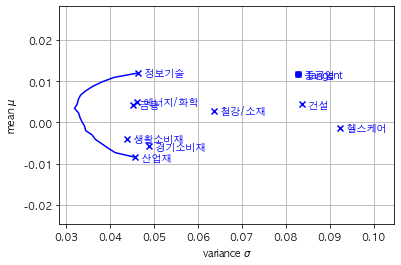

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
Weight,3.995249e-11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#평균분산모델
res1 = optimize_frontier(R, Cov, rf)

display_assets(symbols, R, Cov, color = 'blue')
display_frontier(res1, color = 'blue')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.show()
display(pd.DataFrame({'Weight': res1.W}, index = symbols).T)

### 블랙 리터만 역최적화

In [18]:
mean, var = get_mean_var(W, R, Cov)

lmb = 3 #위험회피계수는 여러 연구에서 사용하고 있는 3을 사용
Pi = np.dot(np.dot(lmb, Cov), W)

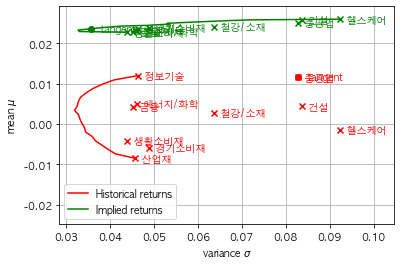

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
Weight,0.025963,0.030795,0.035699,0.093648,0.366738,0.116423,0.106181,0.130958,0.03035,0.063246


In [19]:
#균형수익률로 평균-분산 포트폴리오 최적화
res2 = optimize_frontier(Pi+rf, Cov, rf)

#빨간색 그래프는 평균분산 포트폴리오
display_assets(symbols, R, Cov, color = 'red')
display_frontier(res1, label = 'Historical returns', color = 'red')
#초록색 그래프는 블랙 리터만 평균 분산 포트폴리오
display_assets(symbols, Pi+rf, Cov, color = 'green')
display_frontier(res2, label = 'Implied returns', color = 'green')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.legend(), plt.show()
display(pd.DataFrame({'Weight': res2.W}, index = symbols).T)

#### 평균분산모델과 블랙리터만모델의 차이

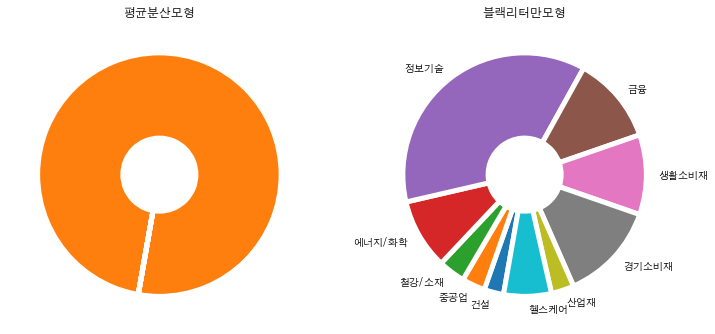

In [20]:
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.pie(res1.W, startangle=260, counterclock=False, wedgeprops=wedgeprops)
plt.title('평균분산모형')

plt.subplot(1, 2, 2)
plt.pie(res2.W, labels = symbols, startangle=260, counterclock=False, wedgeprops=wedgeprops)
plt.title('블랙리터만모형')

plt.show()

평균 분산 모델을 사용했을 때보다 일부 종목에 집중된 포트폴리오를 최적해로 제시하는 코너해 문제가 있는 것을 확인할 수 있는데 블랙 리터만 평균 분산 모델은 평균 분산 모델보다 일부 종목에 집중되어 있지 않은, 코너해 문제를 해결한 모습을 보인다.

### 투자자 전망 행렬

In [21]:
from sklearn import svm, model_selection

In [22]:
#주가지수가 상승하면 +1, 그대로면 0을, 하락하면 -1을 넣는 return 열을 만드는 함수
def make_return(data):
    return_list = [0]
    for i in range(len(data)-1):
        if (data.iloc[i+1][0]/data.iloc[i][0])-1 > 0:
            return_list.append(1)
        elif (data.iloc[i+1][0]/data.iloc[i][0])-1 == 0:
            return_list.append(0)
        else:
            return_list.append(-1)
    data['return'] = return_list

In [23]:
accuracy_set = [] #전망의 신뢰도 
forecast_set = pd.DataFrame() #주가 지수 상승/하락 예측값
for i in range(1151, 1161):
    a = 0
    arr = get_stock_info("20160101", "20191231", str(i), "m")['종가'] #평균 수익률
    df = arr.to_frame()
    df['분산'] = np.std(np.array(arr)) #표준편차
    stoc = [] #stochastics
    for k in range(len(df)):
        stoc.append((df['종가'].values[k]-df['종가'].min())/(df['종가'].max()-df['종가'].min())*100)
    df['stochastics'] = stoc
    disparity = [] #이격도
    for k in range(len(df)):
        disparity.append(df['종가'].values[k]/df['종가'].mean() * 100)
    df['이격도'] = disparity
    make_return(df)
    y_return = df['return']
    y_lately = y_return.iloc[36:]
    y_lately = np.array(y_lately)
    y_train = y_return.iloc[:36]
    y_train = np.array(y_train)
    X = df.drop(['return'], 1)
    X_lately = X.iloc[36:, :]
    X_lately = np.array(X_lately)
    X_train = X.iloc[:36, :]
    X_train = np.array(X_train)
    #2016년부터 2018년까지를 학습 데이터로 활용하고 2019년 1년 후의 데이터를 예측한다.
    model = svm.SVC(kernel = 'rbf', C = 1.25, gamma = 0.1)
    model.fit(X_train, y_train)
    forecast = model.predict(X_lately)
    accuracy = model.score(X_lately, y_lately)
    accuracy_set.append(accuracy)
    forecast_set.insert(a, str(a), forecast, True)
    a += 1
forecast_set.columns = symbols
print(accuracy_set)
forecast_set.index = date
forecast_set

[0.4166666666666667, 0.5, 0.5, 0.5833333333333334, 0.5833333333333334, 0.5833333333333334, 0.5, 0.5833333333333334, 0.4166666666666667, 0.5833333333333334]


,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
2019/1,1,-1,1,-1,1,1,1,-1,1,1
2019/2,1,-1,-1,-1,1,1,1,-1,1,-1
2019/3,1,-1,-1,-1,-1,1,1,-1,-1,1
2019/4,1,-1,-1,-1,1,-1,1,-1,-1,1
2019/5,1,-1,-1,-1,-1,1,1,-1,-1,1
2019/6,1,-1,-1,-1,-1,1,1,-1,-1,1
2019/7,1,-1,-1,-1,1,1,-1,-1,-1,1
2019/8,1,-1,-1,-1,1,1,-1,-1,-1,1
2019/9,1,-1,-1,-1,1,1,1,-1,-1,-1
2019/10,1,-1,-1,-1,1,1,1,-1,-1,1


In [24]:
#투자자 전망, 신뢰도에 대한 데이터가 주어졌을 때 새로운 기대수익률과 공분산을 구하는 함수
def cal_RC(accuracy_set, forecast_set, Pi, Cov):
    #투자자 전망에 나타나는 신뢰도 수준은 불확실성계수로 오차항에 반영
    confidence = np.identity(10)
    for i in range(0, 10):
        confidence[i][i] = (1-accuracy_set[i])/accuracy_set[i]
    
    #예측 분류 결과로부터 투자자 전망 Q 계산
    P = np.identity(10)
    sub = np.dot(P, Pi)
    Q = np.sqrt(np.dot(np.dot(P, Cov), np.ones(10)))
    for i in range(0, 10):
        Q[i] = Q[i] * forecast_set.iloc[10][i]
    Q += sub
    
    tau = 0.025 #상대적 가중치를 나타내는데 많은 연구에서 사용하는 0.025를 활용했다
    #전망에 대한 신뢰도 수준을 사용해 투자자 전망의 불확실성을 고려
    omega = np.dot(np.dot(np.dot(tau, P), Cov), np.transpose(P))
    omega = np.dot(confidence, omega)

    sub_a = np.linalg.inv(np.dot(tau, Cov))
    sub_b = np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), P)
    sub_c = np.dot(np.linalg.inv(np.dot(tau, Cov)), Pi)
    sub_d = np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), Q)
    new_R = np.dot(np.linalg.inv(sub_a + sub_b), (sub_c + sub_d)) #새로운 결합기대수익률 벡터
    new_C = Cov + np.linalg.inv(sub_a + sub_b) #새로운 공분산행렬
    
    return new_R, new_C

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
Weight,6.678812e-17,0.031341,1.823520e-16,4.745772e-16,0.277947,0.375595,0.248395,0.0,0.0,0.066722


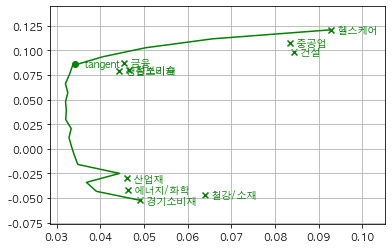

In [25]:
new_R, new_C = cal_RC(accuracy_set, forecast_set, Pi, Cov)
res3 = optimize_frontier(new_R+rf, new_C, rf)
display_assets(symbols, new_R+rf, new_C, color = 'green')
display_frontier(res3, label = 'Implied returns(adjusted views)', color = 'green')
display(pd.DataFrame({'Weight':res3.W}, index = symbols).T)

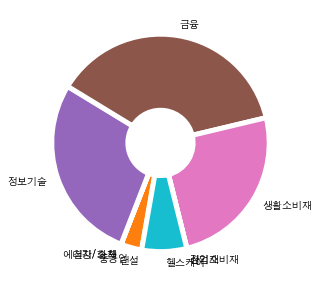

In [26]:
plt.figure(figsize = (5, 5))
plt.pie(res3.W, labels = symbols, startangle=260, counterclock=False, wedgeprops=wedgeprops)
plt.show()

In [27]:
result = pd.DataFrame()
for i in range(1151, 1161):
    df = (get_stock_info("20181201", "20191231", str(i), "m")['종가']).to_frame()
    result = pd.concat([result, df], axis = 1)
date2 = (result.index).strftime("%Y-%m-%d").to_list()
result = result.values.tolist()
result = np.matrix(result)
rows, cols = result.shape
returns = np.empty([rows-1, cols])
for c in range(cols):
    for r in range(rows-1):
        p0, p1 = result[r, c], result[r+1, c]
        returns[r, c] = (p1 / p0) - 1
returns = pd.DataFrame(returns)
returns.columns = symbols
returns.index = date2[1:]

In [28]:
def accumulate_return(res):
    return_accum = returns
    remean = [0 for i in range(return_accum.shape[0])]
    return_accum["return"] = remean
    return_mean = []
    for j in range(return_accum.shape[0]):
        Ret = return_accum.iloc[j].to_list()
        Ret.pop()
        mean = get_mean(res.W, Ret)
        return_mean.append(mean)
    return_accum["return"] = return_mean
    return return_accum

In [29]:
acc_re = accumulate_return(res3)
acc_re

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어,return
2019-01-31,0.055769,0.083829,0.089659,0.057175,0.118027,0.045569,0.012838,0.099340,0.057069,0.000865,0.055794
2019-02-28,-0.059637,-0.055405,0.005186,0.023433,0.006467,-0.006603,0.024271,-0.003373,0.024143,0.020449,0.004974
2019-03-31,-0.011572,-0.082894,-0.041814,-0.054772,-0.000663,-0.038703,-0.014308,-0.032294,-0.061369,-0.089118,-0.026819
2019-04-30,0.000676,0.009993,-0.000061,-0.015489,0.028377,0.040304,-0.006108,0.090269,0.035848,0.033821,0.024078
2019-05-31,-0.046657,-0.057796,-0.085140,-0.073631,-0.085049,-0.037443,-0.094890,-0.090617,-0.037509,-0.093122,-0.069297
2019-06-30,0.047038,0.043019,0.056264,0.018989,0.062248,0.029651,-0.000241,0.038667,0.012120,0.016442,0.030824
2019-07-31,-0.126510,-0.080301,-0.068654,-0.026791,-0.022664,-0.056324,-0.043701,-0.045795,-0.007957,-0.144604,-0.050475
2019-08-31,-0.045110,0.013854,-0.060294,-0.040485,-0.019796,-0.078256,-0.043726,-0.011257,0.005360,-0.036643,-0.047767
2019-09-30,0.056082,0.073460,0.045539,-0.004337,0.037597,0.044068,0.049390,0.036162,0.010583,0.033881,0.043833
2019-10-31,-0.046390,-0.073012,-0.083678,0.031054,0.019469,-0.029233,0.013615,-0.029753,-0.019557,0.171625,0.006976


누적 수익률: 2.95


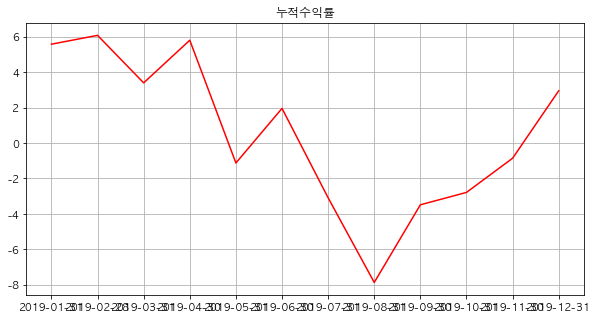

In [30]:
cum_return_svm1 = acc_re[:]['return'].cumsum()*100
print('누적 수익률: %.2f' % cum_return_svm1[-1])
plt.figure(figsize = (10, 5))
plt.plot(cum_return_svm1, color = 'red')
plt.title("누적수익률")
plt.grid(True)
plt.show()

In [31]:
std = cum_return_svm1.std()

sharpe_svm1 = (cum_return_svm1 - rf)/std
sharpe_svm1 = sharpe_svm1[-1]
print('Sharpe ratio: %.2f' % sharpe_svm1)

Sharpe ratio: 0.66


In [32]:
svm1_max = acc_re['return'].max()
svm1_min = acc_re['return'].min()
svm1_mdd = (svm1_max - svm1_min) / svm1_max
print("MDD : %.2f" % svm1_mdd)

MDD : 2.24


#### 예측값 사용하여 다음 달 예측

In [33]:
def pred_past(train):
    accuracy_set2 = [] #전망의 신뢰도 
    forecast_set2 = pd.DataFrame() #주가 지수 상승/하락 예측값
    for i in range(1151, 1161):
        train_set = train
        train_original = train_set
        a = 0
        arr = get_stock_info("20160101", "20191231", str(i), "m")['종가']
        df = arr.to_frame()
        df['분산'] = np.std(np.array(arr)) #표준편차
        stoc = [] #stochastics
        for k in range(len(df)):
            stoc.append((df['종가'].values[k]-df['종가'].min())/(df['종가'].max()-df['종가'].min())*100)
        df['stochastics'] = stoc
        disparity = [] #이격도
        for k in range(len(df)):
            disparity.append(df['종가'].values[k]/df['종가'].mean() * 100)
        df['이격도'] = disparity
        make_return(df)
        y_return = df['return']
        y = np.array(y_return)
        X = df.drop(['return'], 1)
        X = np.array(X)
        L = X.shape[0]
        acc =[]
        while train_set < (L - 2):
            X_train = X[train_set-train_original:train_set]
            y_train = y[train_set-train_original:train_set]
            X_test = X[train_set:train_set+1]
            y_test = y[train_set:train_set+1]
            model = svm.SVC(kernel = 'rbf', C = 1.25, gamma = 0.1)
            model.fit(X_train, y_train)
            forecast = model.predict(X_test)
            accuracy = model.score(X_test, y_test)
            acc.append(accuracy)
            y[train_set] = forecast[0]
            a += 1
            train_set += 1
        accuracy_set2.append(np.mean(acc))
        y_lately = y[36:]
        forecast_set2[i] = y_lately
    forecast_set2.columns = symbols
    return accuracy_set2, forecast_set2

#### 30개월치 데이터를 이용해서 예측

In [34]:
accuracy_set30, forecast_set30 = pred_past(30)
forecast_set30.index = date
forecast_set30

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
2019/1,1,-1,-1,1,1,1,-1,-1,-1,1
2019/2,-1,-1,-1,1,1,1,-1,-1,-1,1
2019/3,1,-1,-1,1,1,-1,-1,-1,-1,1
2019/4,1,-1,-1,1,1,1,-1,-1,-1,1
2019/5,1,-1,-1,1,1,-1,-1,-1,-1,1
2019/6,1,-1,-1,1,1,1,-1,-1,-1,1
2019/7,-1,-1,-1,1,1,1,-1,-1,-1,1
2019/8,-1,-1,-1,1,1,1,-1,-1,-1,1
2019/9,-1,-1,-1,1,1,1,-1,-1,-1,1
2019/10,-1,-1,-1,1,1,1,-1,-1,-1,1


,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
Weight,0.093393,0.093393,0.159462,0.093393,0.093393,0.093393,0.093393,0.093393,0.093393,0.093393


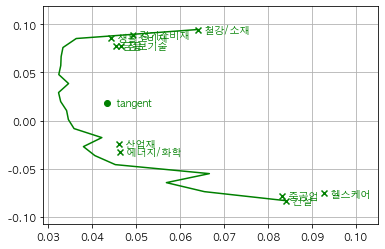

In [35]:
new_R, new_C = cal_RC(accuracy_set30, forecast_set30, Pi, Cov)
res30 = optimize_frontier(new_R+rf, new_C, rf)
display_assets(symbols, new_R+rf, new_C, color = 'green')
display_frontier(res30, label = 'Implied returns(adjusted views)', color = 'green')
display(pd.DataFrame({'Weight':res30.W}, index = symbols).T)

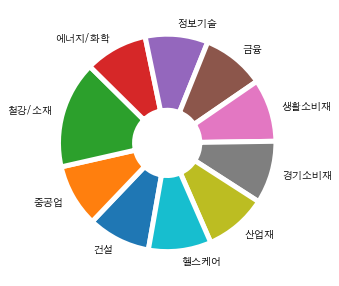

In [36]:
plt.figure(figsize = (5, 5))
plt.pie(res30.W, labels = symbols, startangle=260, counterclock=False, wedgeprops=wedgeprops)
plt.show()

In [37]:
acc_re30 = accumulate_return(res30)
acc_re30

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어,return
2019-01-31,0.055769,0.083829,0.089659,0.057175,0.118027,0.045569,0.012838,0.099340,0.057069,0.000865,0.063840
2019-02-28,-0.059637,-0.055405,0.005186,0.023433,0.006467,-0.006603,0.024271,-0.003373,0.024143,0.020449,-0.001625
2019-03-31,-0.011572,-0.082894,-0.041814,-0.054772,-0.000663,-0.038703,-0.014308,-0.032294,-0.061369,-0.089118,-0.042689
2019-04-30,0.000676,0.009993,-0.000061,-0.015489,0.028377,0.040304,-0.006108,0.090269,0.035848,0.033821,0.020321
2019-05-31,-0.046657,-0.057796,-0.085140,-0.073631,-0.085049,-0.037443,-0.094890,-0.090617,-0.037509,-0.093122,-0.071174
2019-06-30,0.047038,0.043019,0.056264,0.018989,0.062248,0.029651,-0.000241,0.038667,0.012120,0.016442,0.033995
2019-07-31,-0.126510,-0.080301,-0.068654,-0.026791,-0.022664,-0.056324,-0.043701,-0.045795,-0.007957,-0.144604,-0.062748
2019-08-31,-0.045110,0.013854,-0.060294,-0.040485,-0.019796,-0.078256,-0.043726,-0.011257,0.005360,-0.036643,-0.033529
2019-09-30,0.056082,0.073460,0.045539,-0.004337,0.037597,0.044068,0.049390,0.036162,0.010583,0.033881,0.038725
2019-10-31,-0.046390,-0.073012,-0.083678,0.031054,0.019469,-0.029233,0.013615,-0.029753,-0.019557,0.171625,-0.009812


누적 수익률: -3.50


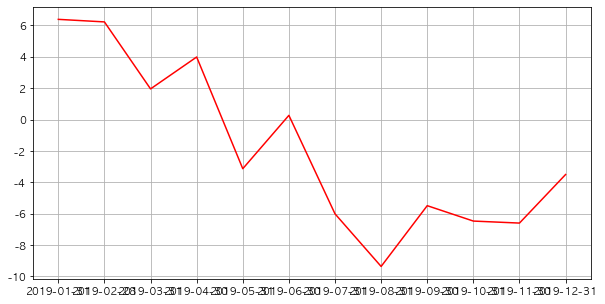

In [38]:
cum_return_svm2 = acc_re30[:]['return'].cumsum()*100
print('누적 수익률: %.2f' % cum_return_svm2[-1])
plt.figure(figsize = (10, 5))
plt.plot(cum_return_svm2, color = 'red')
plt.grid(True)
plt.show()

In [39]:
std = cum_return_svm2.std()

sharpe_svm2 = (cum_return_svm2 - rf)/std
sharpe_svm2 = sharpe_svm2[-1]
print('Sharpe ratio: %.2f' % sharpe_svm2)

Sharpe ratio: -0.65


In [40]:
svm2_max = acc_re30['return'].max()
svm2_min = acc_re30['return'].min()
svm2_mdd = (svm2_max - svm2_min) / svm2_max
print("MDD : %.2f" % svm2_mdd)

MDD : 2.11


#### 예측에 사용되는 개월수 차이로 인한 평균수익률과 샤프지수의 변화

In [41]:
past_n = []
mean_set = []
sharpe_set = []
for n in range(26, 33):
    past_n.append(n)
    accuracyset, forecastset = pred_past(n)
    new_R, new_C = cal_RC(accuracyset, forecastset, Pi, Cov)
    front = optimize_frontier(new_R+rf, new_C, rf)
    acc_re = accumulate_return(front)
    cum_return = acc_re[:]['return'].cumsum()*100
    mean_set.append(cum_return[-1])
    std = cum_return.std()
    sharpe = (cum_return - rf)/std
    sharpe = sharpe[-1]
    sharpe_set.append(sharpe)

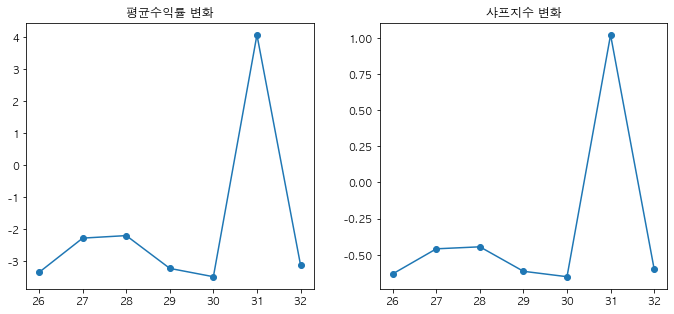

In [42]:
fig = plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(past_n, mean_set, marker = 'o')
plt.title('평균수익률 변화')

plt.subplot(1, 2, 2)
plt.plot(past_n, sharpe_set, marker = 'o')
plt.title('샤프지수 변화')

plt.tight_layout(3)
plt.show()

## LSTM 이용

In [43]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

In [44]:
def create_data(data, window_size):
    dataset = []
    for i in range(len(data)-window_size):
        subset = data[i:(i+window_size+1)]
        dataset.append(subset)
    return np.array(dataset)

### 실제값을 이용한 예측

In [45]:
forecast_set_lstm1 = pd.DataFrame(columns = symbols)
window_size = 12
n = 0
for i in range(1151, 1161):
    arr = get_stock_info("20160101", "20191231", str(i), "m")['종가']
    df = arr.to_frame()
    train = df.iloc[:36, :]
    train = np.array(train)
    test = df.iloc[36-window_size:, :]
    test = np.array(test)
    train = mm.fit_transform(train)
    test = mm.fit_transform(test)
    trainset = create_data(train, window_size)
    testset = create_data(test, window_size)
    x_train = trainset[:, 0:window_size]
    y_train = trainset[:, window_size]
    x_test = testset[:, 0:window_size]
    y_test = testset[:, window_size]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    model = Sequential()
    model.add(LSTM(128, input_shape = (x_train.shape[1], 1), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(x_train, y_train, epochs = 10)
    predictions = model.predict(x_test)
    predictions = mm.inverse_transform(predictions)
    predictions = predictions.reshape(-1)
    predictions = np.insert(predictions, 0, y_train[-1], axis = 0)
    pred = pd.DataFrame(predictions)
    make_return(pred)
    forecast_set_lstm1[symbols[n]] = pred['return']
    n += 1
forecast_set_lstm1

Train on 24 samples
Epoch 1/10
24/24 [==============================] - 7s 273ms/sample - loss: 0.1815 - accuracy: 0.0417
Epoch 2/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.1562 - accuracy: 0.0417
Epoch 3/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.1301 - accuracy: 0.0417
Epoch 4/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.1053 - accuracy: 0.0417
Epoch 5/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0847 - accuracy: 0.0417
Epoch 6/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0753 - accuracy: 0.0417
Epoch 7/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0709 - accuracy: 0.0417
Epoch 8/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0979 - accuracy: 0.0417
Epoch 9/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0970 - accuracy: 0.0417
Epoch 10/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0

Epoch 10/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0659 - accuracy: 0.0000e+00
Train on 24 samples
Epoch 1/10
24/24 [==============================] - 6s 260ms/sample - loss: 0.2116 - accuracy: 0.0417
Epoch 2/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.1391 - accuracy: 0.0417
Epoch 3/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0821 - accuracy: 0.0417
Epoch 4/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0410 - accuracy: 0.0417
Epoch 5/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0272 - accuracy: 0.0417
Epoch 6/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0440 - accuracy: 0.0417
Epoch 7/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0494 - accuracy: 0.0000e+00
Epoch 8/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0567 - accuracy: 0.0000e+00
Epoch 9/10
24/24 [==============================] - 0s 3ms/sample

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,1,1,-1,-1,-1,-1,-1,-1,-1,-1
4,1,1,-1,-1,-1,-1,-1,-1,-1,-1
5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
7,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
8,-1,1,-1,-1,-1,-1,-1,-1,1,-1
9,-1,-1,-1,-1,-1,-1,-1,-1,1,-1


In [46]:
forecast_set_lstm1 = forecast_set_lstm1.drop(forecast_set_lstm1.index[0])
forecast_set_lstm1.index = date
forecast_set_lstm1

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
2019/1,1,1,1,1,1,1,1,1,1,1
2019/2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2019/3,1,1,-1,-1,-1,-1,-1,-1,-1,-1
2019/4,1,1,-1,-1,-1,-1,-1,-1,-1,-1
2019/5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2019/6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2019/7,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
2019/8,-1,1,-1,-1,-1,-1,-1,-1,1,-1
2019/9,-1,-1,-1,-1,-1,-1,-1,-1,1,-1
2019/10,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [47]:
acc_set_lstm1 = []
n = 0
for i in range(1151, 1161):
    count = 0
    arr = get_stock_info("20181201", "20191231", str(i), "m")['종가'] #평균 수익률
    df = arr.to_frame()
    make_return(df)
    ret = df['return'].to_list()
    ret = ret[1:]
    for i in range(len(ret)):
        if ret[i] == forecast_set_lstm1[symbols[n]].tolist()[i]:
            count += 1
    acc = count / len(ret)
    acc_set_lstm1.append(acc)
    n += 1
print(acc_set_lstm1)

[0.5833333333333334, 0.5833333333333334, 0.6666666666666666, 0.6666666666666666, 0.5833333333333334, 0.5833333333333334, 0.5833333333333334, 0.75, 0.6666666666666666, 0.5]


,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
Weight,2.903150e-17,7.247151e-17,0.078666,0.0,0.172111,0.0,0.0,0.433045,0.316179,2.625096e-16


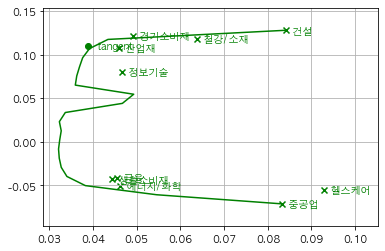

In [48]:
newR, newC = cal_RC(acc_set_lstm1, forecast_set_lstm1, Pi, Cov)
res_lstm1 = optimize_frontier(newR+rf, newC, rf)
display_assets(symbols, newR+rf, newC, color = 'green')
display_frontier(res_lstm1, label = 'Implied returns(adjusted views)', color = 'green')
display(pd.DataFrame({'Weight':res_lstm1.W}, index = symbols).T)

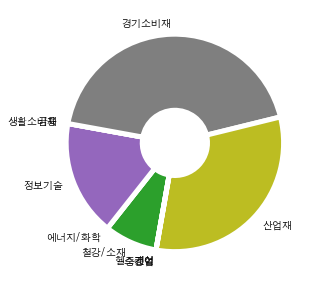

In [49]:
plt.figure(figsize = (5, 5))
plt.pie(res_lstm1.W, labels = symbols, startangle=260, counterclock=False, wedgeprops=wedgeprops)
plt.show()

In [50]:
acc_re_lstm1 = accumulate_return(res_lstm1)
acc_re_lstm1

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어,return
2019-01-31,0.055769,0.083829,0.089659,0.057175,0.118027,0.045569,0.012838,0.099340,0.057069,0.000865,0.088429
2019-02-28,-0.059637,-0.055405,0.005186,0.023433,0.006467,-0.006603,0.024271,-0.003373,0.024143,0.020449,0.007694
2019-03-31,-0.011572,-0.082894,-0.041814,-0.054772,-0.000663,-0.038703,-0.014308,-0.032294,-0.061369,-0.089118,-0.036791
2019-04-30,0.000676,0.009993,-0.000061,-0.015489,0.028377,0.040304,-0.006108,0.090269,0.035848,0.033821,0.055304
2019-05-31,-0.046657,-0.057796,-0.085140,-0.073631,-0.085049,-0.037443,-0.094890,-0.090617,-0.037509,-0.093122,-0.072436
2019-06-30,0.047038,0.043019,0.056264,0.018989,0.062248,0.029651,-0.000241,0.038667,0.012120,0.016442,0.035716
2019-07-31,-0.126510,-0.080301,-0.068654,-0.026791,-0.022664,-0.056324,-0.043701,-0.045795,-0.007957,-0.144604,-0.031649
2019-08-31,-0.045110,0.013854,-0.060294,-0.040485,-0.019796,-0.078256,-0.043726,-0.011257,0.005360,-0.036643,-0.011330
2019-09-30,0.056082,0.073460,0.045539,-0.004337,0.037597,0.044068,0.049390,0.036162,0.010583,0.033881,0.029059
2019-10-31,-0.046390,-0.073012,-0.083678,0.031054,0.019469,-0.029233,0.013615,-0.029753,-0.019557,0.171625,-0.022300


누적 수익률: 7.20


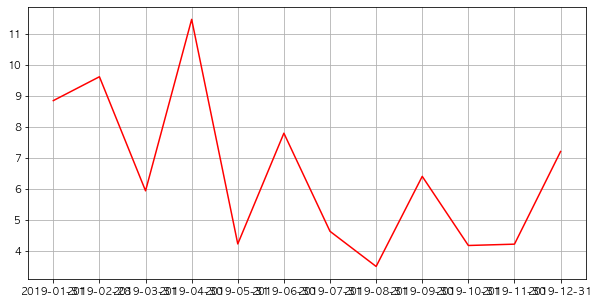

In [51]:
cum_return_lstm1 = acc_re_lstm1[:]['return'].cumsum()*100
print('누적 수익률: %.2f' % cum_return_lstm1[-1])
plt.figure(figsize = (10, 5))
plt.plot(cum_return_lstm1, color = 'red')
plt.grid(True)
plt.show()

In [52]:
std = cum_return_lstm1.std()

sharpe = (cum_return_lstm1 - rf)/std
sharpe = sharpe[-1]
print('Sharpe ratio: %.2f' % sharpe)

Sharpe ratio: 2.83


In [53]:
lstm1_max = acc_re_lstm1['return'].max()
lstm1_min = acc_re_lstm1['return'].min()
lstm1_mdd = (lstm1_max - lstm1_min) / lstm1_max
print("MDD : %.2f" % lstm1_mdd)

MDD : 1.82


### 예측값을 이용한 예측

In [54]:
def lstm_acc(window_size):
    forecast_set = pd.DataFrame(columns = symbols)
    n = 0
    for i in range(1151, 1161):
        arr = get_stock_info("20160101", "20191231", str(i), "m")['종가']
        df = arr.to_frame()
        train = df.iloc[:36, :]
        train = np.array(train)
        test = df.iloc[36-window_size:, :]
        test = np.array(test)
        train = mm.fit_transform(train)
        test = mm.fit_transform(test)
        trainset = create_data(train, window_size)
        testset = create_data(test, window_size)
        x_train = trainset[:, 0:window_size]
        y_train = trainset[:, window_size]
        x_test = testset[:, 0:window_size]
        y_test = testset[:, window_size]
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        model = Sequential()
        model.add(LSTM(64, input_shape = (x_train.shape[1], 1)))
        model.add(Dense(1))
        model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])
        model.fit(x_train, y_train, epochs = 10)
        predictions = []
        sample_in = x_test[0]
        for i in range(12):
            sample_in = np.reshape(sample_in, (1, window_size, 1))
            pred_out = model.predict(sample_in)
            sample_in = np.append(sample_in, pred_out)
            sample_in = np.delete(sample_in, 0)
            predictions.append(pred_out)
        predictions = np.array(predictions)
        predictions = predictions.reshape(-1)
        predictions = np.insert(predictions, 0, y_test[-1], axis = 0)
        pred = pd.DataFrame(predictions)
        make_return(pred)
        forecast_set[symbols[n]] = pred['return']
        n += 1
    forecast_set = forecast_set.drop(forecast_set.index[0])
    forecast_set.index = date
    acc_set = []
    n = 0
    for i in range(1151, 1161):
        count = 0
        arr = get_stock_info("20181201", "20191231", str(i), "m")['종가'] #평균 수익률
        df = arr.to_frame()
        make_return(df)
        ret = df['return'].to_list()
        ret = ret[1:]
        for i in range(len(ret)):
            if ret[i] == forecast_set[symbols[n]].tolist()[i]:
                count += 1
        acc = count / len(ret)
        acc_set.append(acc)
        n += 1
    return forecast_set, acc_set

In [55]:
forecast_12, acc_12 = lstm_acc(12)

Train on 24 samples
Epoch 1/10
24/24 [==============================] - 2s 83ms/sample - loss: 0.1988 - accuracy: 0.0417
Epoch 2/10
24/24 [==============================] - 0s 870us/sample - loss: 0.1800 - accuracy: 0.0417
Epoch 3/10
24/24 [==============================] - 0s 820us/sample - loss: 0.1626 - accuracy: 0.0417
Epoch 4/10
24/24 [==============================] - 0s 913us/sample - loss: 0.1466 - accuracy: 0.0417
Epoch 5/10
24/24 [==============================] - 0s 1ms/sample - loss: 0.1319 - accuracy: 0.0417
Epoch 6/10
24/24 [==============================] - 0s 917us/sample - loss: 0.1183 - accuracy: 0.0417
Epoch 7/10
24/24 [==============================] - 0s 885us/sample - loss: 0.1060 - accuracy: 0.0417
Epoch 8/10
24/24 [==============================] - 0s 930us/sample - loss: 0.0950 - accuracy: 0.0417
Epoch 9/10
24/24 [==============================] - 0s 874us/sample - loss: 0.0854 - accuracy: 0.0417
Epoch 10/10
24/24 [==============================] - 0s 882us/sam

Epoch 9/10
24/24 [==============================] - 0s 843us/sample - loss: 0.1008 - accuracy: 0.0417
Epoch 10/10
24/24 [==============================] - 0s 874us/sample - loss: 0.0764 - accuracy: 0.0417
Train on 24 samples
Epoch 1/10
24/24 [==============================] - 2s 85ms/sample - loss: 0.2351 - accuracy: 0.0417
Epoch 2/10
24/24 [==============================] - 0s 890us/sample - loss: 0.1921 - accuracy: 0.0417
Epoch 3/10
24/24 [==============================] - 0s 977us/sample - loss: 0.1542 - accuracy: 0.0417
Epoch 4/10
24/24 [==============================] - 0s 961us/sample - loss: 0.1211 - accuracy: 0.0417
Epoch 5/10
24/24 [==============================] - 0s 887us/sample - loss: 0.0926 - accuracy: 0.0417
Epoch 6/10
24/24 [==============================] - 0s 892us/sample - loss: 0.0687 - accuracy: 0.0417
Epoch 7/10
24/24 [==============================] - 0s 882us/sample - loss: 0.0493 - accuracy: 0.0417
Epoch 8/10
24/24 [==============================] - 0s 887us/s

In [56]:
forecast_12

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
2019/1,1,1,1,1,-1,1,1,1,1,1
2019/2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2019/3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2019/4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2019/5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2019/6,-1,-1,-1,1,-1,-1,-1,-1,-1,1
2019/7,-1,-1,-1,1,-1,-1,-1,-1,-1,1
2019/8,-1,-1,-1,1,-1,-1,-1,-1,-1,1
2019/9,-1,-1,-1,1,-1,-1,-1,-1,-1,1
2019/10,-1,-1,-1,1,1,-1,-1,-1,-1,-1


,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
Weight,1.294352e-17,0.0,0.086232,0.142856,0.188935,5.982971e-17,0.273176,0.308802,1.410995e-17,7.338687e-17


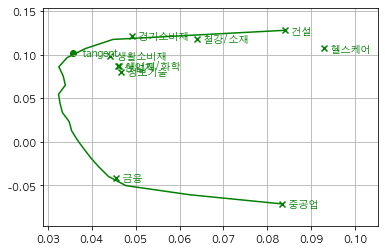

In [57]:
newR, newC = cal_RC(acc_12, forecast_12, Pi, Cov)
res_12 = optimize_frontier(newR+rf, newC, rf)
display_assets(symbols, newR+rf, newC, color = 'green')
display_frontier(res_12, label = 'Implied returns(adjusted views)', color = 'green')
display(pd.DataFrame({'Weight':res_12.W}, index = symbols).T)

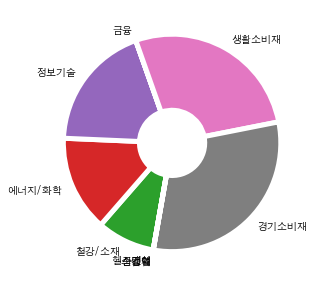

In [58]:
plt.figure(figsize = (5, 5))
plt.pie(res_12.W, labels = symbols, startangle=260, counterclock=False, wedgeprops=wedgeprops)
plt.show()

In [59]:
acc_re12 = accumulate_return(res_12)
acc_re12

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어,return
2019-01-31,0.055769,0.083829,0.089659,0.057175,0.118027,0.045569,0.012838,0.099340,0.057069,0.000865,0.072382
2019-02-28,-0.059637,-0.055405,0.005186,0.023433,0.006467,-0.006603,0.024271,-0.003373,0.024143,0.020449,0.010605
2019-03-31,-0.011572,-0.082894,-0.041814,-0.054772,-0.000663,-0.038703,-0.014308,-0.032294,-0.061369,-0.089118,-0.025436
2019-04-30,0.000676,0.009993,-0.000061,-0.015489,0.028377,0.040304,-0.006108,0.090269,0.035848,0.033821,0.029350
2019-05-31,-0.046657,-0.057796,-0.085140,-0.073631,-0.085049,-0.037443,-0.094890,-0.090617,-0.037509,-0.093122,-0.087834
2019-06-30,0.047038,0.043019,0.056264,0.018989,0.062248,0.029651,-0.000241,0.038667,0.012120,0.016442,0.031200
2019-07-31,-0.126510,-0.080301,-0.068654,-0.026791,-0.022664,-0.056324,-0.043701,-0.045795,-0.007957,-0.144604,-0.040109
2019-08-31,-0.045110,0.013854,-0.060294,-0.040485,-0.019796,-0.078256,-0.043726,-0.011257,0.005360,-0.036643,-0.030144
2019-09-30,0.056082,0.073460,0.045539,-0.004337,0.037597,0.044068,0.049390,0.036162,0.010583,0.033881,0.035070
2019-10-31,-0.046390,-0.073012,-0.083678,0.031054,0.019469,-0.029233,0.013615,-0.029753,-0.019557,0.171625,-0.004570


누적 수익률: 2.78


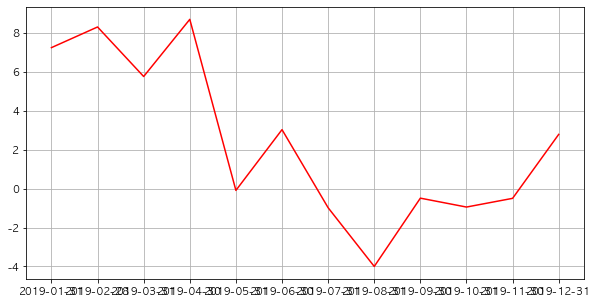

In [60]:
cum_return_lstm2 = acc_re12[:]['return'].cumsum()*100
print('누적 수익률: %.2f' % cum_return_lstm2[-1])
plt.figure(figsize = (10, 5))
plt.plot(cum_return_lstm2, color = 'red')
plt.grid(True)
plt.show()

In [61]:
std = cum_return_lstm2.std()

sharpe_lstm2 = (cum_return_lstm2 - rf)/std
sharpe_lstm2 = sharpe_lstm2[-1]
print('Sharpe ratio: %.2f' % sharpe_lstm2)

Sharpe ratio: 0.65


In [62]:
lstm2_max = acc_re12['return'].max()
lstm2_min = acc_re12['return'].min()
lstm2_mdd = (lstm2_max - lstm2_min) / lstm2_max
print("MDD : %.2f" % lstm2_mdd)

MDD : 2.21


### SVM과 LSTM 비교

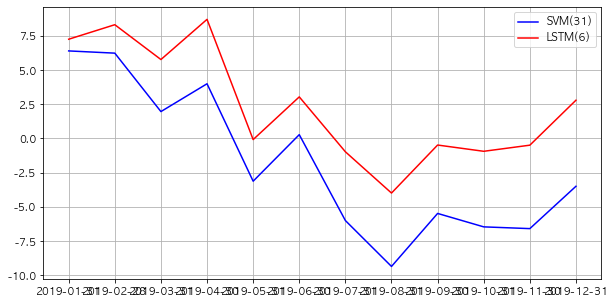

In [97]:
plt.figure(figsize = (10, 5))
plt.plot(cum_return_svm2, color = 'blue')
plt.plot(cum_return_lstm2, color = 'red')
plt.grid(True)
plt.legend(['SVM(31)', 'LSTM(6)'])
plt.show()

## GRU 모델

In [63]:
from tensorflow.keras.layers import GRU

### 실제값을 이용한 예측

In [68]:
gru_forecast1 = pd.DataFrame(columns = symbols)
window_size = 12
n = 0
for i in range(1151, 1161):
    arr = get_stock_info("20160101", "20191231", str(i), "m")['종가']
    df = arr.to_frame()
    train = df.iloc[:36, :]
    train = np.array(train)
    test = df.iloc[36-window_size:, :]
    test = np.array(test)
    train = mm.fit_transform(train)
    test = mm.fit_transform(test)
    trainset = create_data(train, window_size)
    testset = create_data(test, window_size)
    x_train = trainset[:, 0:window_size]
    y_train = trainset[:, window_size]
    x_test = testset[:, 0:window_size]
    y_test = testset[:, window_size]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    gru_model = Sequential()
    gru_model.add(GRU(units = 50, activation = "tanh", input_shape = (x_train.shape[1], 1), return_sequences = True))
    gru_model.add(Dropout(0.2))
    gru_model.add(GRU(units = 50, activation = "tanh", input_shape = (x_train.shape[1], 1), return_sequences = True))
    gru_model.add(Dropout(0.2))
    gru_model.add(GRU(units = 50, activation = "tanh", input_shape = (x_train.shape[1], 1), return_sequences = True))
    gru_model.add(Dropout(0.2))
    gru_model.add(GRU(units = 50, activation = "tanh"))
    gru_model.add(Dropout(0.2))
    gru_model.add(Dense(units = 1))
    gru_model.compile(loss = 'mean_squared_error', optimizer = "adam")
    gru_model.fit(x_train, y_train, epochs = 10)
    predict = gru_model.predict(x_test)
    predictions = mm.inverse_transform(predict)
    predictions = predictions.reshape(-1)
    predictions = np.insert(predictions, 0, y_train[-1], axis = 0)
    pred = pd.DataFrame(predictions)
    make_return(pred) #하락, 유지, 상승을 -1, 0, 1로 표현하는 열 만듦
    gru_forecast1[symbols[n]] = pred['return']
    n += 1
gru_forecast1

Train on 24 samples
Epoch 1/10
24/24 [==============================] - 8s 322ms/sample - loss: 0.2014
Epoch 2/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.1547
Epoch 3/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.1155
Epoch 4/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0862
Epoch 5/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0748
Epoch 6/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0647
Epoch 7/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0768
Epoch 8/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0856
Epoch 9/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0803
Epoch 10/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0874
Train on 24 samples
Epoch 1/10
24/24 [==============================] - 11s 469ms/sample - loss: 0.6109
Epoch 2/10
24/24 [==============================] - 0s 3ms/samp

Epoch 10/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0963


,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1
2,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
5,-1,-1,-1,-1,-1,-1,-1,1,-1,-1
6,-1,-1,-1,-1,-1,-1,-1,1,1,-1
7,-1,-1,-1,-1,-1,-1,-1,1,1,-1
8,-1,-1,-1,-1,-1,-1,-1,1,1,-1
9,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [69]:
gru_forecast1 = gru_forecast1.drop(gru_forecast1.index[0])
gru_forecast1.index = date
gru_forecast1

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
2019/1,1,1,1,1,1,1,1,1,1,1
2019/2,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
2019/3,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
2019/4,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
2019/5,-1,-1,-1,-1,-1,-1,-1,1,-1,-1
2019/6,-1,-1,-1,-1,-1,-1,-1,1,1,-1
2019/7,-1,-1,-1,-1,-1,-1,-1,1,1,-1
2019/8,-1,-1,-1,-1,-1,-1,-1,1,1,-1
2019/9,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2019/10,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [70]:
gru_acc1 = []
n = 0
for i in range(1151, 1161):
    count = 0
    arr = get_stock_info("20181201", "20191231", str(i), "m")['종가'] #평균 수익률
    df = arr.to_frame()
    make_return(df)
    ret = df['return'].to_list()
    ret = ret[1:]
    for i in range(len(ret)):
        if ret[i] == gru_forecast1[symbols[n]].tolist()[i]:
            count += 1
    acc = count / len(ret)
    gru_acc1.append(acc)
    n += 1
print(gru_acc1)

[0.6666666666666666, 0.5, 0.5833333333333334, 0.6666666666666666, 0.5833333333333334, 0.5833333333333334, 0.5833333333333334, 0.4166666666666667, 0.5, 0.5]


,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
Weight,0.0,2.612054e-16,0.0,0.0,0.433558,6.503334e-16,0.0,0.0,0.566442,5.857901e-16


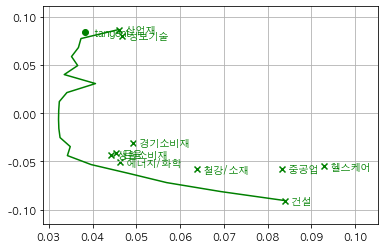

In [71]:
gru1_newR, gru1_newC = cal_RC(gru_acc1, gru_forecast1, Pi, Cov)
res_gru1 = optimize_frontier(gru1_newR+rf, gru1_newC, rf)
display_assets(symbols, gru1_newR+rf, gru1_newC, color = 'green')
display_frontier(res_gru1, label = 'Implied returns(adjusted views)', color = 'green')
display(pd.DataFrame({'Weight':res_gru1.W}, index = symbols).T)

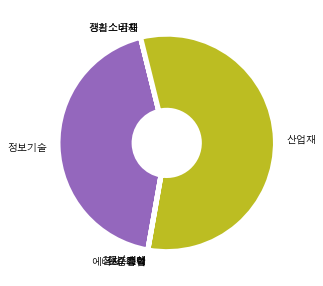

In [72]:
plt.figure(figsize = (5, 5))
plt.pie(res_gru1.W, labels = symbols, startangle=260, counterclock=False, wedgeprops=wedgeprops)
plt.show()

In [73]:
acc_re_gru1 = accumulate_return(res_gru1)
acc_re_gru1

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어,return
2019-01-31,0.055769,0.083829,0.089659,0.057175,0.118027,0.045569,0.012838,0.099340,0.057069,0.000865,0.083498
2019-02-28,-0.059637,-0.055405,0.005186,0.023433,0.006467,-0.006603,0.024271,-0.003373,0.024143,0.020449,0.016480
2019-03-31,-0.011572,-0.082894,-0.041814,-0.054772,-0.000663,-0.038703,-0.014308,-0.032294,-0.061369,-0.089118,-0.035049
2019-04-30,0.000676,0.009993,-0.000061,-0.015489,0.028377,0.040304,-0.006108,0.090269,0.035848,0.033821,0.032608
2019-05-31,-0.046657,-0.057796,-0.085140,-0.073631,-0.085049,-0.037443,-0.094890,-0.090617,-0.037509,-0.093122,-0.058120
2019-06-30,0.047038,0.043019,0.056264,0.018989,0.062248,0.029651,-0.000241,0.038667,0.012120,0.016442,0.033854
2019-07-31,-0.126510,-0.080301,-0.068654,-0.026791,-0.022664,-0.056324,-0.043701,-0.045795,-0.007957,-0.144604,-0.014333
2019-08-31,-0.045110,0.013854,-0.060294,-0.040485,-0.019796,-0.078256,-0.043726,-0.011257,0.005360,-0.036643,-0.005546
2019-09-30,0.056082,0.073460,0.045539,-0.004337,0.037597,0.044068,0.049390,0.036162,0.010583,0.033881,0.022295
2019-10-31,-0.046390,-0.073012,-0.083678,0.031054,0.019469,-0.029233,0.013615,-0.029753,-0.019557,0.171625,-0.002637


누적 수익률: 10.88


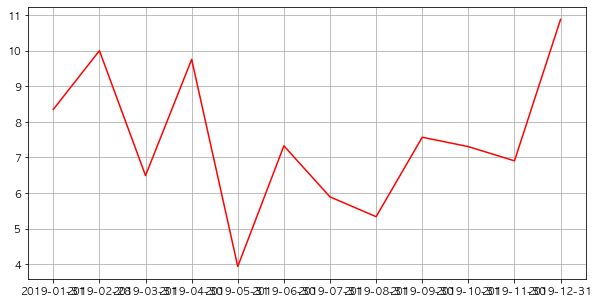

In [74]:
cum_return_gru1 = acc_re_gru1[:]['return'].cumsum()*100
print('누적 수익률: %.2f' % cum_return_gru1[-1])
plt.figure(figsize = (10, 5))
plt.plot(cum_return_gru1, color = 'red')
plt.grid(True)
plt.show()

In [75]:
std_gru1 = cum_return_gru1.std()

sharpe_gru1 = (cum_return_gru1 - rf)/std_gru1
sharpe_gru1 = sharpe_gru1[-1]
print('Sharpe ratio: %.2f' % sharpe_gru1)

Sharpe ratio: 5.38


In [76]:
gru1_max = acc_re_gru1['return'].max()
gru1_min = acc_re_gru1['return'].min()
gru1_mdd = (gru1_max - gru1_min) / gru1_max
print("MDD : %.2f" % gru1_mdd)

MDD : 1.70


### LSTM과 GRU 비교 (실제값을 이용한 예측)

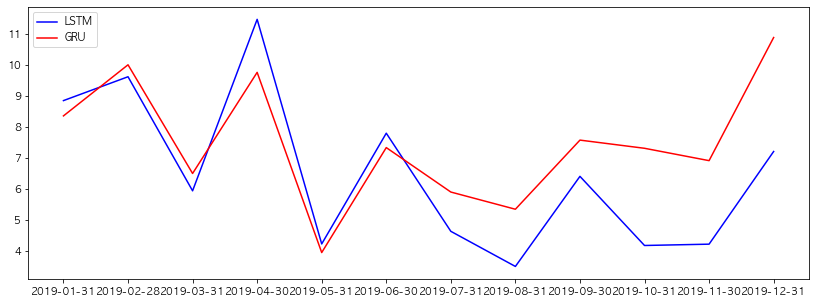

In [77]:
plt.figure(figsize = (14, 5))
plt.plot(cum_return_lstm1, color = 'blue')
plt.plot(cum_return_gru1, color = 'red')
plt.legend(['LSTM', 'GRU'])
plt.show()

### 예측값을 이용한 예측

In [85]:
gru_forecast = pd.DataFrame(columns = symbols)
window_size = 12
n = 0
for i in range(1151, 1161):
    arr = get_stock_info("20160101", "20191231", str(i), "m")['종가']
    df = arr.to_frame()
    train = df.iloc[:36, :]
    train = np.array(train)
    test = df.iloc[36-window_size:, :]
    test = np.array(test)
    train = mm.fit_transform(train)
    test = mm.fit_transform(test)
    trainset = create_data(train, window_size)
    testset = create_data(test, window_size)
    x_train = trainset[:, 0:window_size]
    y_train = trainset[:, window_size]
    x_test = testset[:, 0:window_size]
    y_test = testset[:, window_size]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    GRU_model = Sequential()
    GRU_model.add(GRU(units = 50, activation = "tanh", input_shape = (x_train.shape[1], 1), return_sequences = True))
    GRU_model.add(Dropout(0.2))
    GRU_model.add(GRU(units = 50, activation = "tanh"))
    GRU_model.add(Dropout(0.2))
    GRU_model.add(Dense(units = 1))
    GRU_model.compile(loss = 'mean_squared_error', optimizer = SGD(lr = 0.1, decay = 1e-7, momentum = 0.9, nesterov = False))
    GRU_model.fit(x_train, y_train, epochs = 10)
    gru_predictions = []
    sample_in = x_test[0]
    for i in range(12):
        sample_in = np.reshape(sample_in, (1, window_size, 1))
        pred_out = GRU_model.predict(sample_in)
        sample_in = np.append(sample_in, pred_out)
        sample_in = np.delete(sample_in, 0)
        gru_predictions.append(pred_out)
    gru_predictions = np.array(gru_predictions)
    gru_predictions = gru_predictions.reshape(-1)
    gru_predictions = np.insert(gru_predictions, 0, y_test[-1], axis = 0)
    gru_pred = pd.DataFrame(gru_predictions)
    make_return(gru_pred)
    gru_forecast[symbols[n]] = gru_pred['return']
    n += 1
gru_forecast

Train on 24 samples
Epoch 1/10
24/24 [==============================] - 4s 167ms/sample - loss: 0.1762
Epoch 2/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.0598
Epoch 3/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.1856
Epoch 4/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.1021
Epoch 5/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.0841
Epoch 6/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.1402
Epoch 7/10
24/24 [==============================] - 0s 3ms/sample - loss: 0.0836
Epoch 8/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.0684
Epoch 9/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.1131
Epoch 10/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.0856
Train on 24 samples
Epoch 1/10
24/24 [==============================] - 4s 164ms/sample - loss: 0.6522
Epoch 2/10
24/24 [==============================] - 0s 2ms/sampl

Epoch 10/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.0994


,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,-1,1,1,1,1,1
2,-1,1,1,1,1,1,-1,1,1,1
3,-1,1,1,1,1,1,-1,1,1,1
4,-1,1,1,1,1,1,-1,1,1,1
5,-1,1,1,1,1,1,-1,1,1,1
6,-1,1,1,1,1,1,-1,1,1,1
7,-1,1,1,1,1,1,-1,1,1,1
8,-1,1,1,1,1,1,-1,1,1,1
9,-1,1,1,1,1,1,-1,1,1,1


In [86]:
gru_forecast = gru_forecast.drop(gru_forecast.index[0])
gru_forecast.index = date
gru_forecast

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
2019/1,1,1,1,1,-1,1,1,1,1,1
2019/2,-1,1,1,1,1,1,-1,1,1,1
2019/3,-1,1,1,1,1,1,-1,1,1,1
2019/4,-1,1,1,1,1,1,-1,1,1,1
2019/5,-1,1,1,1,1,1,-1,1,1,1
2019/6,-1,1,1,1,1,1,-1,1,1,1
2019/7,-1,1,1,1,1,1,-1,1,1,1
2019/8,-1,1,1,1,1,1,-1,1,1,1
2019/9,-1,1,1,1,1,1,-1,1,1,1
2019/10,1,1,1,1,1,1,-1,1,1,1


In [87]:
gru_acc = []
n = 0
for i in range(1151, 1161):
    count = 0
    arr = get_stock_info("20181201", "20191231", str(i), "m")['종가'] #평균 수익률
    df = arr.to_frame()
    make_return(df)
    gru_ret = df['return'].to_list()
    gru_ret = gru_ret[1:]
    for i in range(len(gru_ret)):
        if gru_ret[i] == gru_forecast[symbols[n]].tolist()[i]:
            count += 1
    acc = count / len(gru_ret)
    gru_acc.append(acc)
    n += 1
print(gru_acc)

[0.6666666666666666, 0.5, 0.5, 0.4166666666666667, 0.5833333333333334, 0.5, 0.5833333333333334, 0.5, 0.5833333333333334, 0.5833333333333334]


,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
Weight,6.340243e-17,0.0,0.0,0.050414,0.246448,0.161749,0.0,0.123964,0.417425,6.402214e-17


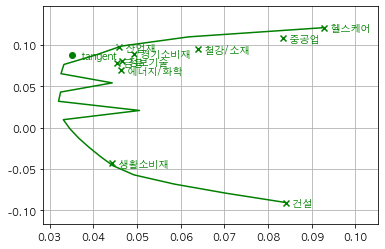

In [88]:
grunewR, grunewC = cal_RC(gru_acc, gru_forecast, Pi, Cov)
res_gru = optimize_frontier(grunewR+rf, grunewC, rf)
display_assets(symbols, grunewR+rf, grunewC, color = 'green')
display_frontier(res_gru, label = 'Implied returns(adjusted views)', color = 'green')
display(pd.DataFrame({'Weight':res_gru.W}, index = symbols).T)

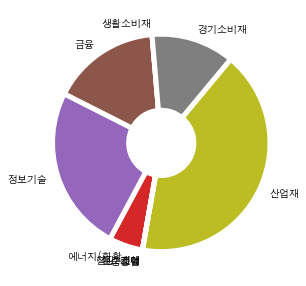

In [89]:
plt.figure(figsize = (5, 5))
plt.pie(res_gru.W, labels = symbols, startangle=260, counterclock=False, wedgeprops=wedgeprops)
plt.show()

In [90]:
acc_re_gru = accumulate_return(res_gru)
acc_re_gru

,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어,return
2019-01-31,0.055769,0.083829,0.089659,0.057175,0.118027,0.045569,0.012838,0.099340,0.057069,0.000865,0.075477
2019-02-28,-0.059637,-0.055405,0.005186,0.023433,0.006467,-0.006603,0.024271,-0.003373,0.024143,0.020449,0.011367
2019-03-31,-0.011572,-0.082894,-0.041814,-0.054772,-0.000663,-0.038703,-0.014308,-0.032294,-0.061369,-0.089118,-0.038805
2019-04-30,0.000676,0.009993,-0.000061,-0.015489,0.028377,0.040304,-0.006108,0.090269,0.035848,0.033821,0.038885
2019-05-31,-0.046657,-0.057796,-0.085140,-0.073631,-0.085049,-0.037443,-0.094890,-0.090617,-0.037509,-0.093122,-0.057619
2019-06-30,0.047038,0.043019,0.056264,0.018989,0.062248,0.029651,-0.000241,0.038667,0.012120,0.016442,0.030947
2019-07-31,-0.126510,-0.080301,-0.068654,-0.026791,-0.022664,-0.056324,-0.043701,-0.045795,-0.007957,-0.144604,-0.025045
2019-08-31,-0.045110,0.013854,-0.060294,-0.040485,-0.019796,-0.078256,-0.043726,-0.011257,0.005360,-0.036643,-0.018735
2019-09-30,0.056082,0.073460,0.045539,-0.004337,0.037597,0.044068,0.049390,0.036162,0.010583,0.033881,0.025076
2019-10-31,-0.046390,-0.073012,-0.083678,0.031054,0.019469,-0.029233,0.013615,-0.029753,-0.019557,0.171625,-0.010217


누적 수익률: 6.60


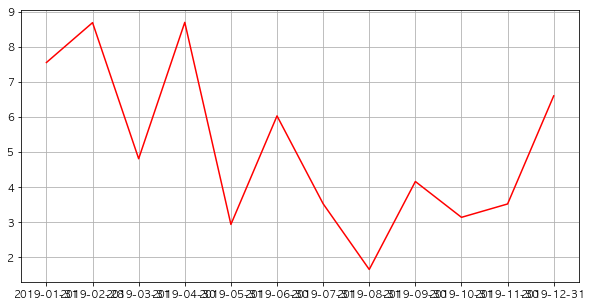

In [91]:
cum_return_gru = acc_re_gru[:]['return'].cumsum()*100
print('누적 수익률: %.2f' % cum_return_gru[-1])
plt.figure(figsize = (10, 5))
plt.plot(cum_return_gru, color = 'red')
plt.grid(True)
plt.show()

In [92]:
std = cum_return_gru.std()

sharpe = (cum_return_gru - rf)/std
sharpe = sharpe[-1]
print('Sharpe ratio: %.2f' % sharpe)

Sharpe ratio: 2.79


In [93]:
gru2_max = acc_re_gru['return'].max()
gru2_min = acc_re_gru['return'].min()
gru2_mdd = (gru2_max - gru2_min) / gru2_max
print("MDD : %.2f" % gru2_mdd)

MDD : 1.76


### LSTM과 GRU 비교 (예측값을 이용한 예측)

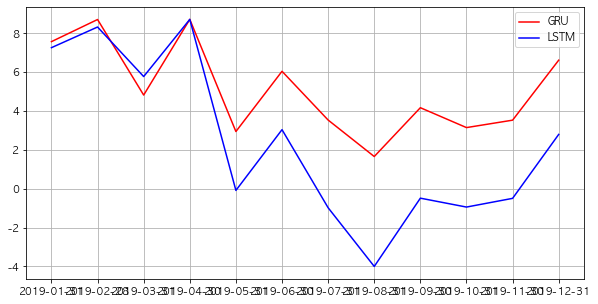

In [94]:
plt.figure(figsize = (10, 5))
plt.plot(cum_return_gru, color = 'red')
plt.plot(cum_return_lstm2, color = 'blue')
plt.grid(True)
plt.legend(['GRU', 'LSTM'])
plt.show()

### window size에 따른 누적 수익률/샤프지수 변화

In [78]:
def gru_window(window_size):
    gru_forecast = pd.DataFrame(columns = symbols)
    n = 0
    for i in range(1151, 1161):
        arr = get_stock_info("20160101", "20191231", str(i), "m")['종가']
        df = arr.to_frame()
        train = df.iloc[:36, :]
        train = np.array(train)
        test = df.iloc[36-window_size:, :]
        test = np.array(test)
        train = mm.fit_transform(train)
        test = mm.fit_transform(test)
        trainset = create_data(train, window_size)
        testset = create_data(test, window_size)
        x_train = trainset[:, 0:window_size]
        y_train = trainset[:, window_size]
        x_test = testset[:, 0:window_size]
        y_test = testset[:, window_size]
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        GRU_model = Sequential()
        GRU_model.add(GRU(units = 50, activation = "tanh", input_shape = (x_train.shape[1], 1), return_sequences = True))
        GRU_model.add(Dropout(0.2))
        GRU_model.add(GRU(units = 50, activation = "tanh"))
        GRU_model.add(Dropout(0.2))
        GRU_model.add(Dense(units = 1))
        GRU_model.compile(loss = 'mean_squared_error', optimizer = SGD(lr = 0.1, decay = 1e-7, momentum = 0.9, nesterov = False))
        GRU_model.fit(x_train, y_train, epochs = 10)
        gru_predictions = []
        sample_in = x_test[0]
        for i in range(12):
            sample_in = np.reshape(sample_in, (1, window_size, 1))
            pred_out = GRU_model.predict(sample_in)
            sample_in = np.append(sample_in, pred_out)
            sample_in = np.delete(sample_in, 0)
            gru_predictions.append(pred_out)
        gru_predictions = np.array(gru_predictions)
        gru_predictions = gru_predictions.reshape(-1)
        gru_predictions = np.insert(gru_predictions, 0, y_test[-1], axis = 0)
        gru_pred = pd.DataFrame(gru_predictions)
        make_return(gru_pred)
        gru_forecast[symbols[n]] = gru_pred['return']
        n += 1
    gru_forecast = gru_forecast.drop(gru_forecast.index[0])
    gru_forecast.index = date
    gru_forecast
    gru_acc = []
    n = 0
    for i in range(1151, 1161):
        count = 0
        arr = get_stock_info("20181201", "20191231", str(i), "m")['종가'] #평균 수익률
        df = arr.to_frame()
        make_return(df)
        gru_ret = df['return'].to_list()
        gru_ret = gru_ret[1:]
        for i in range(len(gru_ret)):
            if gru_ret[i] == gru_forecast[symbols[n]].tolist()[i]:
                count += 1
        acc = count / len(gru_ret)
        gru_acc.append(acc)
        n += 1
    return gru_forecast, gru_acc

In [85]:
window = []
mean_gru = []
sharpe_gru = []
for n in range(6, 13):
    window.append(n)
    forecast, accuracy = gru_window(n)
    new_R, new_C = cal_RC(accuracy, forecast, Pi, Cov)
    front = optimize_frontier(new_R+rf, new_C, rf)
    acc_re = accumulate_return(front)
    cum_return = acc_re[:]['return'].cumsum()*100
    mean_gru.append(cum_return[-1])
    std = cum_return.std()
    sharpe = (cum_return - rf)/std
    sharpe = sharpe[-1]
    sharpe_gru.append(sharpe)

Train on 30 samples
Epoch 1/10
30/30 [==============================] - 5s 156ms/sample - loss: 0.1260
Epoch 2/10
30/30 [==============================] - 0s 916us/sample - loss: 0.0525
Epoch 3/10
30/30 [==============================] - 0s 1ms/sample - loss: 0.1162
Epoch 4/10
30/30 [==============================] - 0s 978us/sample - loss: 0.1060
Epoch 5/10
30/30 [==============================] - 0s 875us/sample - loss: 0.0513
Epoch 6/10
30/30 [==============================] - 0s 872us/sample - loss: 0.0894
Epoch 7/10
30/30 [==============================] - 0s 903us/sample - loss: 0.0869
Epoch 8/10
30/30 [==============================] - 0s 868us/sample - loss: 0.0545
Epoch 9/10
30/30 [==============================] - 0s 959us/sample - loss: 0.0695
Epoch 10/10
30/30 [==============================] - 0s 1ms/sample - loss: 0.0776
Train on 30 samples
Epoch 1/10
30/30 [==============================] - 4s 139ms/sample - loss: 0.3843
Epoch 2/10
30/30 [==============================] 

Epoch 8/10
30/30 [==============================] - 0s 928us/sample - loss: 0.0546
Epoch 9/10
30/30 [==============================] - 0s 893us/sample - loss: 0.1110
Epoch 10/10
30/30 [==============================] - 0s 923us/sample - loss: 0.1073
Train on 29 samples
Epoch 1/10
29/29 [==============================] - 5s 166ms/sample - loss: 0.1595
Epoch 2/10
29/29 [==============================] - 0s 4ms/sample - loss: 0.0597
Epoch 3/10
29/29 [==============================] - 0s 5ms/sample - loss: 0.1327
Epoch 4/10
29/29 [==============================] - 0s 4ms/sample - loss: 0.1425
Epoch 5/10
29/29 [==============================] - 0s 6ms/sample - loss: 0.0604
Epoch 6/10
29/29 [==============================] - 0s 4ms/sample - loss: 0.1312
Epoch 7/10
29/29 [==============================] - 0s 4ms/sample - loss: 0.1150
Epoch 8/10
29/29 [==============================] - 0s 3ms/sample - loss: 0.0516
Epoch 9/10
29/29 [==============================] - 0s 3ms/sample - loss: 0.0891

Epoch 6/10
29/29 [==============================] - 0s 978us/sample - loss: 0.1882
Epoch 7/10
29/29 [==============================] - 0s 1ms/sample - loss: 0.1182
Epoch 8/10
29/29 [==============================] - 0s 972us/sample - loss: 0.0554
Epoch 9/10
29/29 [==============================] - 0s 982us/sample - loss: 0.1090
Epoch 10/10
29/29 [==============================] - 0s 1ms/sample - loss: 0.1213
Train on 28 samples
Epoch 1/10
28/28 [==============================] - 6s 210ms/sample - loss: 0.1504
Epoch 2/10
28/28 [==============================] - 0s 1ms/sample - loss: 0.0535
Epoch 3/10
28/28 [==============================] - 0s 1ms/sample - loss: 0.1474
Epoch 4/10
28/28 [==============================] - 0s 1ms/sample - loss: 0.0998
Epoch 5/10
28/28 [==============================] - 0s 1ms/sample - loss: 0.0662
Epoch 6/10
28/28 [==============================] - 0s 1ms/sample - loss: 0.1148
Epoch 7/10
28/28 [==============================] - 0s 1ms/sample - loss: 0.1003

Epoch 5/10
28/28 [==============================] - 0s 1ms/sample - loss: 0.0852
Epoch 6/10
28/28 [==============================] - 0s 1ms/sample - loss: 0.1524
Epoch 7/10
28/28 [==============================] - 0s 1ms/sample - loss: 0.0906
Epoch 8/10
28/28 [==============================] - 0s 1ms/sample - loss: 0.0586
Epoch 9/10
28/28 [==============================] - 0s 1ms/sample - loss: 0.1301
Epoch 10/10
28/28 [==============================] - 0s 1ms/sample - loss: 0.0809
Train on 27 samples
Epoch 1/10
27/27 [==============================] - 6s 227ms/sample - loss: 0.1619
Epoch 2/10
27/27 [==============================] - 0s 2ms/sample - loss: 0.0716
Epoch 3/10
27/27 [==============================] - 0s 2ms/sample - loss: 0.1687
Epoch 4/10
27/27 [==============================] - 0s 1ms/sample - loss: 0.0852
Epoch 5/10
27/27 [==============================] - 0s 1ms/sample - loss: 0.0774
Epoch 6/10
27/27 [==============================] - 0s 1ms/sample - loss: 0.1117
Epoch

Epoch 4/10
27/27 [==============================] - 0s 1ms/sample - loss: 0.0923
Epoch 5/10
27/27 [==============================] - 0s 1ms/sample - loss: 0.1203
Epoch 6/10
27/27 [==============================] - 0s 1ms/sample - loss: 0.2213
Epoch 7/10
27/27 [==============================] - 0s 2ms/sample - loss: 0.1430
Epoch 8/10
27/27 [==============================] - 0s 2ms/sample - loss: 0.0565
Epoch 9/10
27/27 [==============================] - 0s 1ms/sample - loss: 0.1216
Epoch 10/10
27/27 [==============================] - 0s 2ms/sample - loss: 0.1247
Train on 26 samples
Epoch 1/10
26/26 [==============================] - 4s 172ms/sample - loss: 0.1668
Epoch 2/10
26/26 [==============================] - 0s 2ms/sample - loss: 0.0631
Epoch 3/10
26/26 [==============================] - 0s 3ms/sample - loss: 0.1753
Epoch 4/10
26/26 [==============================] - 0s 2ms/sample - loss: 0.0801
Epoch 5/10
26/26 [==============================] - 0s 2ms/sample - loss: 0.0901
Epoch

Epoch 3/10
26/26 [==============================] - 0s 2ms/sample - loss: 0.4006
Epoch 4/10
26/26 [==============================] - 0s 2ms/sample - loss: 0.1410
Epoch 5/10
26/26 [==============================] - 0s 2ms/sample - loss: 0.0824
Epoch 6/10
26/26 [==============================] - 0s 2ms/sample - loss: 0.2252
Epoch 7/10
26/26 [==============================] - 0s 2ms/sample - loss: 0.1848
Epoch 8/10
26/26 [==============================] - 0s 2ms/sample - loss: 0.0833
Epoch 9/10
26/26 [==============================] - 0s 2ms/sample - loss: 0.0645
Epoch 10/10
26/26 [==============================] - 0s 2ms/sample - loss: 0.1234
Train on 25 samples
Epoch 1/10
25/25 [==============================] - 4s 171ms/sample - loss: 0.1770
Epoch 2/10
25/25 [==============================] - 0s 2ms/sample - loss: 0.0674
Epoch 3/10
25/25 [==============================] - 0s 2ms/sample - loss: 0.2071
Epoch 4/10
25/25 [==============================] - 0s 2ms/sample - loss: 0.0876
Epoch

Epoch 2/10
25/25 [==============================] - 0s 2ms/sample - loss: 0.0751
Epoch 3/10
25/25 [==============================] - 0s 2ms/sample - loss: 0.2599
Epoch 4/10
25/25 [==============================] - 0s 2ms/sample - loss: 0.0952
Epoch 5/10
25/25 [==============================] - 0s 2ms/sample - loss: 0.0795
Epoch 6/10
25/25 [==============================] - 0s 2ms/sample - loss: 0.1831
Epoch 7/10
25/25 [==============================] - 0s 2ms/sample - loss: 0.1294
Epoch 8/10
25/25 [==============================] - 0s 2ms/sample - loss: 0.0497
Epoch 9/10
25/25 [==============================] - 0s 2ms/sample - loss: 0.0953
Epoch 10/10
25/25 [==============================] - 0s 2ms/sample - loss: 0.1199
Train on 24 samples
Epoch 1/10
24/24 [==============================] - 4s 182ms/sample - loss: 0.1848
Epoch 2/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.0615
Epoch 3/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.1861
Epoch

Train on 24 samples
Epoch 1/10
24/24 [==============================] - 5s 192ms/sample - loss: 0.3848
Epoch 2/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.0723
Epoch 3/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.3119
Epoch 4/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.2158
Epoch 5/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.0611
Epoch 6/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.1363
Epoch 7/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.1931
Epoch 8/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.1127
Epoch 9/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.0494
Epoch 10/10
24/24 [==============================] - 0s 2ms/sample - loss: 0.0762


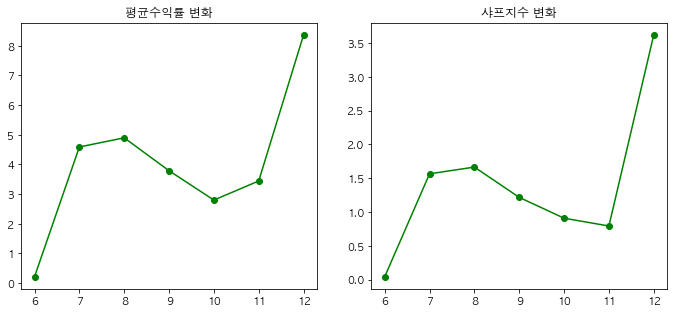

In [86]:
fig = plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(window, mean_gru, marker = 'o', color = 'green')
plt.title('평균수익률 변화')

plt.subplot(1, 2, 2)
plt.plot(window, sharpe_gru, marker = 'o', color = 'green')
plt.title('샤프지수 변화')

plt.tight_layout(3)
plt.show()

## 세가지 예측기 비교

### 실제값을 이용한 예측

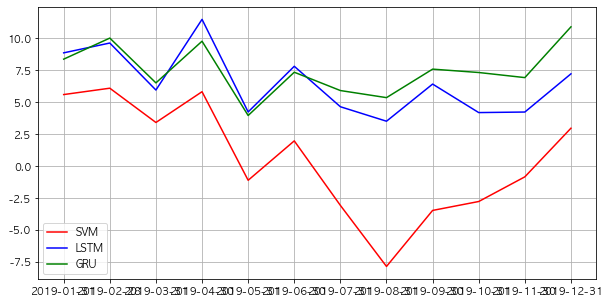

In [95]:
plt.figure(figsize = (10, 5))
plt.plot(cum_return_svm1, color = 'red')
plt.plot(cum_return_lstm1, color = 'blue')
plt.plot(cum_return_gru1, color = 'green')
plt.grid(True)
plt.legend(['SVM', 'LSTM', 'GRU'])
plt.show()

### 예측값을 이용한 예측

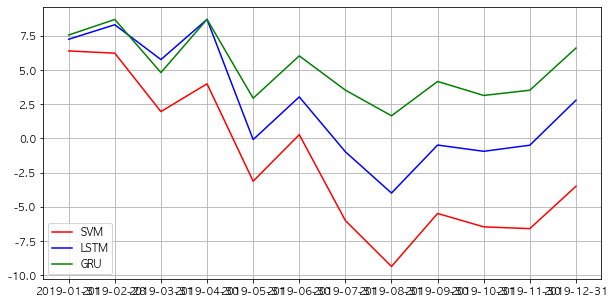

In [96]:
plt.figure(figsize = (10, 5))
plt.plot(cum_return_svm2, color = 'red')
plt.plot(cum_return_lstm2, color = 'blue')
plt.plot(cum_return_gru, color = 'green')
plt.grid(True)
plt.legend(['SVM', 'LSTM', 'GRU'])
plt.show()